In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [6]:
def img_detect_red_circle(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 100, 100])  # Нижняя граница первого диапазона
    upper_red1 = np.array([10, 255, 255])  # Верхняя граница первого диапазона

    lower_red2 = np.array([160, 150, 150])  # Нижняя граница второго диапазона
    upper_red2 = np.array([180, 255, 255])  # Верхняя граница второго диапазона

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    blurred = cv2.GaussianBlur(red_mask, (9, 9), 2)

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=200,
        param1=10,
        param2=15,
        minRadius=10,
        maxRadius=50
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(image, (x, y), r, (0, 255, 0), 4)
            cv2.circle(image, (x, y), 2, (0, 255, 255), 3)

    return image


def img_detect_color(image, show=False):
    """
    Выделение светлых областей на изображении.
    """
    color_select = np.copy(image)
    thresholds = (
            (image[:, :, 0] < 150) | (image[:, :, 1] < 150) | (image[:, :, 2] < 140)
    )
    color_select[thresholds] = [0, 0, 0]

    if show:
        plt.imshow(color_select)
        plt.title("Выделение +- белого цвета")
        plt.show()

    return color_select


# Укажите путь к исполняемому файлу tesseract, если это необходимо
def image_detection_bus_line(image):
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

    # Загрузка изображения
    base_image = image

    # Шаг 1: Преобразование в оттенки серого

    # Шаг 2: Усиление контраста
    image = img_detect_color(image, show=True)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Шаг 3: Применение пороговой бинаризации
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    median = cv2.medianBlur(binary, 5)

    kernel = np.ones((3, 3), np.uint8)
    processed_image = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernel)

    custom_config = r'--oem 3 --psm 8'

    # Распознавание текста
    recognized_text = pytesseract.image_to_data(processed_image, output_type=pytesseract.Output.DICT,
                                                config=custom_config)

    # Вывод распознанного текста
    print("Распознанный текст:", recognized_text["left"])
    n_boxes = len(recognized_text['level'])
    for i in range(n_boxes):
        print(recognized_text['text'][i])
        if recognized_text['text'][i].lower() == 'a':
            print("YEYS")
            (x, y, w, h) = (recognized_text['left'][i], recognized_text['top'][i], recognized_text['width'][i],
                            recognized_text['height'][i])
            return (x, y, w, h)

    # Показать промежуточный результат (если необходимо)
    return (0, 0, 0, 0)


def mask_area_on_image(image, show=False):
    """
    Выделение области дороги на изображении.
    """
    mask = np.zeros_like(image)
    height, width, _ = mask.shape
    polygon = np.array(
        [
            [
                (int(width * 0.4), height),
                (int(width * 0.6), height),
                (int(width * 0.6), int(height * 0.7)),
                (int(width * 0.4), int(height * 0.7)),
            ]
        ],
        np.int32,
    )

    cv2.fillPoly(mask, polygon, (255, 255, 255))
    masked_image = cv2.bitwise_and(image, mask)

    if show:
        image_with_border = masked_image.copy()
        cv2.polylines(
            image_with_border, [polygon], isClosed=True, color=(255, 0, 0), thickness=1
        )
        plt.imshow(image_with_border)
        plt.title("Выделение региона дороги на изображении")
        plt.show()

    return masked_image


def lines_detect(image, show=False):
    """
    Обнаружение линий на изображении.
    """
    median = cv2.medianBlur(image, 5)
    edges = cv2.Canny(median, 30, 100)

    if show:
        plt.imshow(edges, cmap="gray")
        plt.title("Выделение линий")
        plt.show()

    return edges


def detect_road_marking(base_image, image, show=False):
    """
    Обнаружение дорожной разметки на изображении.
    """
    lines = cv2.HoughLinesP(
        image, rho=1, theta=np.pi / 180, threshold=65, minLineLength=100, maxLineGap=50
    )

    if show:
        line_image = np.zeros_like(base_image)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
        combined_image = cv2.addWeighted(base_image, 0.8, line_image, 1, 0)
        plt.imshow(combined_image)
        plt.title("Выделение дорожной разметки")
        plt.show()

    return lines if lines is not None else []


def line_length(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


def does_line_intersect_zone(x1, y1, x2, y2, zone_start, zone_end, height):
    """
    Проверка, пересекает ли линия зону.
    """
    if (zone_start <= x1 <= zone_end) or (zone_start <= x2 <= zone_end):
        return True

    A = y2 - y1
    B = x1 - x2
    C = (x2 - x1) * y1 - (y2 - y1) * x1

    y_start = (-A * zone_start - C) / B if B != 0 else None
    y_end = (-A * zone_end - C) / B if B != 0 else None

    return (y_start is not None and 0 <= y_start <= height) or (
            y_end is not None and 0 <= y_end <= height
    )


def does_center_intersect_line_center(x1, y1, x2, y2, image_center_x):
    """
    Проверка, пересекает ли центр изображения линию.
    """
    mid_x = (x1 + x2) / 2
    line_len = line_length(x1, y1, x2, y2)
    offset = 0.2 * line_len
    center_start_x = mid_x - offset
    center_end_x = mid_x + offset

    return center_start_x <= image_center_x <= center_end_x


def line_crossing_check(
        lines, image, min_len_line=60, ignore_horizontal=True, verbose=False
):
    """
    Проверка, пересекает ли линия центральную часть изображения.
    """
    height, width, _ = image.shape
    zone_width = width * 0.1
    zone_start = (width / 2) - (zone_width / 2)
    zone_end = (width / 2) + (zone_width / 2)
    image_center_x = width / 2

    if len(lines) == 0 or len(lines) > 20:
        return False

    for line in lines:
        x1, y1, x2, y2 = line[0]
        line_len = line_length(x1, y1, x2, y2)
        intersects_zone = does_line_intersect_zone(
            x1, y1, x2, y2, zone_start, zone_end, height
        )
        center_intersects_line_center = does_center_intersect_line_center(
            x1, y1, x2, y2, image_center_x
        )

        if ignore_horizontal and abs(y2 - y1) < height * 0.2:
            continue

        if center_intersects_line_center:
            if verbose:
                print(
                    f"Line with length {int(line_len)} intersects the 10% center zone."
                )
            return True

    return False


def process_frame(frame, show=False):
    image = img_detect_color(frame, show)
    image = mask_area_on_image(image, show)
    image = lines_detect(image, show)
    lines = detect_road_marking(frame, image, show)
    violation = line_crossing_check(lines, frame, min_len_line=60)
    return violation


def main_analise(video_path, frames_to_take=50, show=False, debug_sec=[]):
    """
    Анализ кадров из видео на нарушения.
    """
    result_analysis = []
    violation_frames = []
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    count_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    freq = max(1, count_frame // frames_to_take)

    print(f"Частота выборки кадров: {freq}")
    success, frame = cap.read()
    count = 0

    with tqdm(total=count_frame // freq, desc="Processing frames") as pbar:
        while success:
            if count % freq == 0:
                time_sec = count // fps
                if time_sec in debug_sec:
                    show = True

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, None, fx=0.5, fy=0.5)

                if show:
                    plt.imshow(frame)
                    plt.title("Current Frame")
                    plt.show()

                violation = process_frame(frame, show=show)
                result_analysis.append([violation, time_sec])

                if violation:
                    violation_frames.append(frame)

                pbar.update(1)

                if time_sec in debug_sec:
                    show = False
                    print(f"\n\nОбработка кадра на {time_sec} секунде")
                    print("Правило нарушено" if violation else "Правило не нарушено")
                    print("----------------------------")

            success, frame = cap.read()
            count += 1

    cap.release()
    cv2.destroyAllWindows()
    return [result_analysis, violation_frames]

In [7]:
def detection_task(video_path) -> tuple[str, list]:
    result_analysis, violation_frames = main_analise(
        video_path, frames_to_take=500, show=False, debug_sec=[]
    )
    return result_analysis, violation_frames

In [8]:
video_path = r'/content/drive/MyDrive/Dataset/akn00006_fqGg6dtL.mov'
result_analysis, violation_frames = detection_task(video_path)

print("Result Analysis:", result_analysis)
print("Violation Frames Count:", len(violation_frames))



Частота выборки кадров: 17


Processing frames: 529it [02:36,  3.39it/s]

Result Analysis: [[False, 0.0], [False, 0.0], [False, 1.0], [False, 1.0], [False, 2.0], [False, 2.0], [False, 3.0], [False, 3.0], [False, 4.0], [False, 5.0], [False, 5.0], [False, 6.0], [False, 6.0], [False, 7.0], [False, 7.0], [False, 8.0], [False, 9.0], [False, 9.0], [False, 10.0], [False, 10.0], [False, 11.0], [False, 11.0], [False, 12.0], [False, 13.0], [False, 13.0], [False, 14.0], [False, 14.0], [False, 15.0], [False, 15.0], [False, 16.0], [False, 17.0], [False, 17.0], [False, 18.0], [False, 18.0], [False, 19.0], [False, 19.0], [False, 20.0], [False, 20.0], [False, 21.0], [False, 22.0], [False, 22.0], [False, 23.0], [False, 23.0], [False, 24.0], [False, 24.0], [False, 25.0], [False, 26.0], [False, 26.0], [False, 27.0], [False, 27.0], [False, 28.0], [False, 28.0], [False, 29.0], [False, 30.0], [False, 30.0], [False, 31.0], [False, 31.0], [False, 32.0], [False, 32.0], [False, 33.0], [False, 34.0], [False, 34.0], [False, 35.0], [False, 35.0], [False, 36.0], [False, 36.0], [False, 37

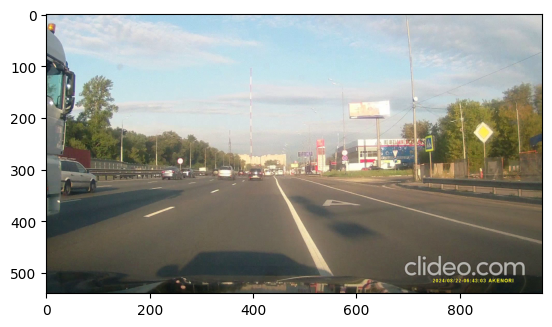

In [9]:
for i in violation_frames:
  plt.imshow(i)